<a href="https://colab.research.google.com/github/google/jax-md/blob/master/notebooks/nve_neighbor_list.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Imports & Utils

!pip install jax-md

import numpy as onp

from jax.config import config ; config.update('jax_enable_x64', True)
import jax.numpy as np
from jax import random
from jax import jit
from jax import lax

import time

from jax_md import space, smap, energy, quantity, simulate, partition

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
  
sns.set_style(style='white')

def format_plot(x, y):  
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

# Constant Energy Simulation With Neighbor Lists

Setup some system parameters.

In [2]:
Nx = particles_per_side = 80
spacing = np.float32(1.25)
side_length = Nx * spacing

R = onp.stack([onp.array(r) for r in onp.ndindex(Nx, Nx)]) * spacing
R = np.array(R, np.float64)

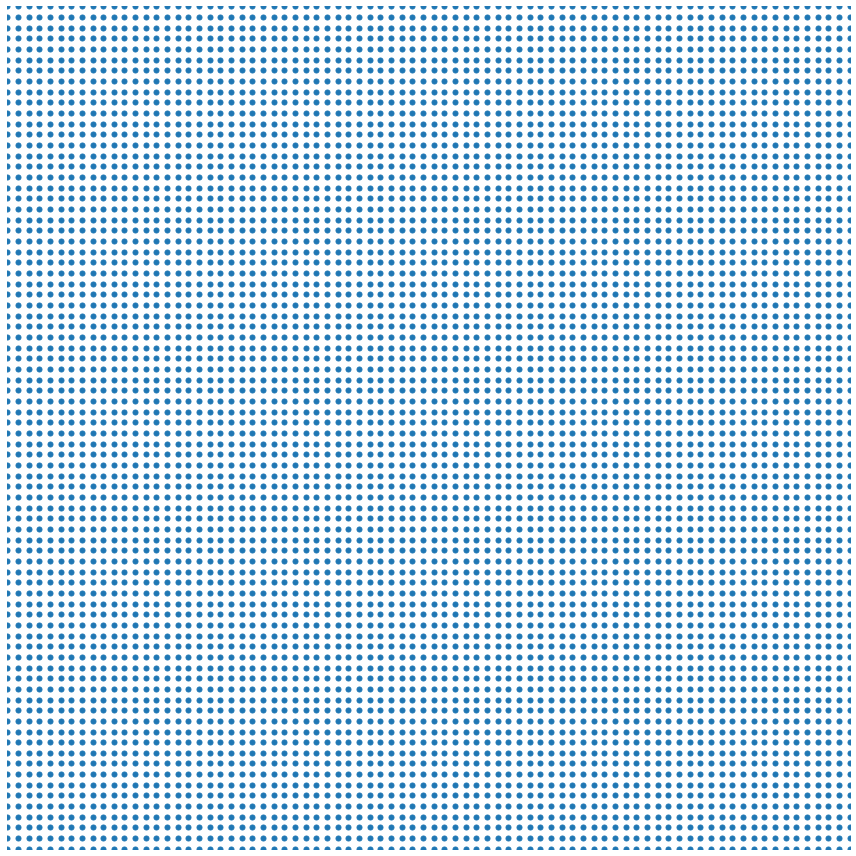

In [3]:
#@title Draw the initial state
ms = 10
R_plt = onp.array(R)

plt.plot(R_plt[:, 0], R_plt[:, 1], 'o', markersize=ms * 0.5)

plt.xlim([0, np.max(R[:, 0])])
plt.ylim([0, np.max(R[:, 1])])

plt.axis('off')

finalize_plot((2, 2))

Construct two versions of the energy function with and without neighbor lists.

In [4]:
displacement, shift = space.periodic(side_length)

neighbor_fn, energy_fn = energy.lennard_jones_neighbor_list(displacement, 
                                                            side_length)
energy_fn = jit(energy_fn)

exact_energy_fn = jit(energy.lennard_jones_pair(displacement))

nbrs = neighbor_fn(R)

In [6]:
# Run once so that we avoid the jit compilation time.
print('E = {}'.format(energy_fn(R, neighbor=nbrs)))
print('E_ex = {}'.format(exact_energy_fn(R)))

E = -11526.081609728004
E_ex = -11526.081609727156


In [9]:
%%timeit
energy_fn(R, neighbor=nbrs).block_until_ready()

The slowest run took 8.25 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 329 µs per loop


In [8]:
%%timeit
exact_energy_fn(R).block_until_ready()

1000 loops, best of 3: 1.11 ms per loop


In [11]:
displacement, shift = space.periodic(side_length)

init_fn, apply_fn = simulate.nve(energy_fn, shift, 1e-3)
state = init_fn(random.PRNGKey(0), R, neighbor=nbrs)

def body_fn(i, state):
  state, nbrs = state
  nbrs = neighbor_fn(state.position, nbrs)
  state = apply_fn(state, neighbor=nbrs)
  return state, nbrs

step = 0
while step < 40:
  new_state, nbrs = lax.fori_loop(0, 100, body_fn, (state, nbrs))
  if nbrs.did_buffer_overflow:
    nbrs = neighbor_fn(state.position)
  else:
    state = new_state
    step += 1

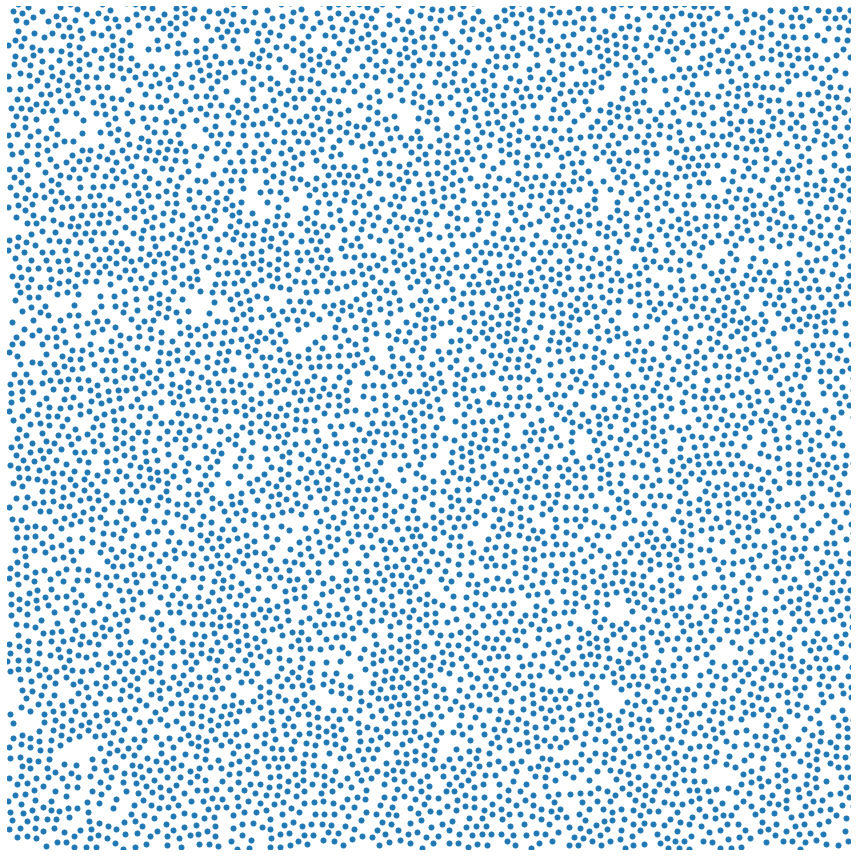

In [12]:
#@title Draw the final state
ms = 10
R_plt = onp.array(state.position)

plt.plot(R_plt[:, 0], R_plt[:, 1], 'o', markersize=ms * 0.5)

plt.xlim([0, np.max(R[:, 0])])
plt.ylim([0, np.max(R[:, 1])])

plt.axis('off')

finalize_plot((2, 2))